# Lecture 17: Multi-objective analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('DonPedroData.csv')
df['date'] = pd.to_datetime(df.DATE, format='%m/%d/%y' )
df['year'] = df.date.dt.year
df['dayofyear'] = df.date.dt.dayofyear
df.loc[df.INFLOW_cfs<0, 'INFLOW_cfs']=np.nan
df.INFLOW_cfs = df.INFLOW_cfs.interpolate()
df.head()

,STATION_ID,DURATION,DATE,INFLOW_cfs,OUTFLOW_cfs,STORAGE_af,date,year,dayofyear
0,DNP,D,1/1/94,213.0,213.0,NaN,1994-01-01,1994,1
1,DNP,D,1/2/94,213.0,213.0,1586937.0,1994-01-02,1994,2
2,DNP,D,1/3/94,656.0,204.0,1584792.0,1994-01-03,1994,3
3,DNP,D,1/4/94,656.0,204.0,1584792.0,1994-01-04,1994,4
4,DNP,D,1/5/94,867.0,NaN,1583721.0,1994-01-05,1994,5


In [2]:
#Hydropower vs flood control
#Power plant of 168 MW and 5500 cfs max 
#Info https://www.ferc.gov/sites/default/files/2020-04/P-2299-082-DEIS.pdf

stor_height = [[0,500000,1000000,1500000,2000000,2030000],[290,650,730,785,825,830]]


def height_from_stor(storage):
    storage_exceeded = 0
    while storage_exceeded==0:
        for i in range(6):
            if stor_height[0][i] > storage:
                height = stor_height[1][i-1] + (storage-stor_height[0][i-1])*(stor_height[1][i]-stor_height[1][i-1])/(stor_height[0][i]-stor_height[0][i-1])
                storage_exceeded=1
                break
    return height

def power(height, flow):
    power = 0.91 * height * flow / 1.181e04
    return power

# Energy price on average ~$50/MWh

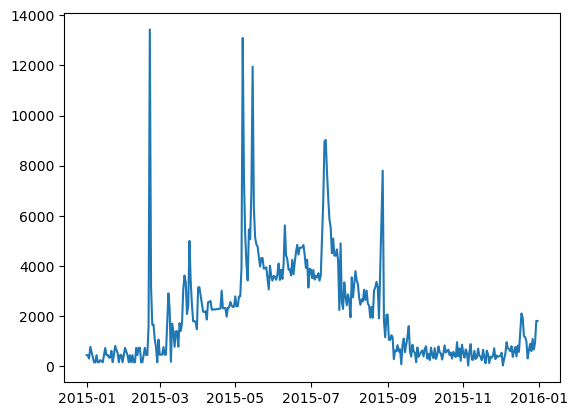

In [3]:
#Let's analyze 2015
df15 = df.loc[df.year==2015].reset_index(drop=True)
plt.plot(df15.date,df15.INFLOW_cfs)
#Flows in excess of 9000 cfs have the potential to cause significant damage - Let's say that 

<BarContainer object of 365 artists>

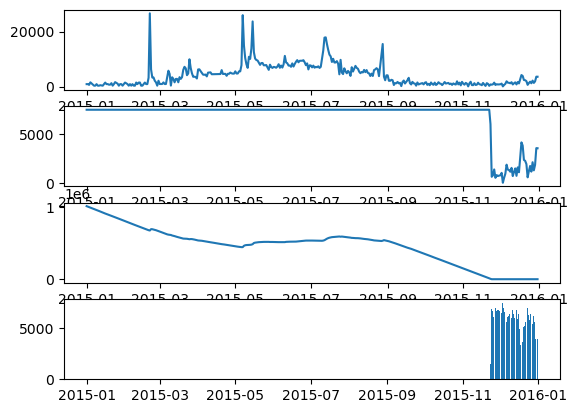

In [6]:
#Objective 1: supply
#Objective 2: hydropower
#Objective 3: flow alteration

#SLOP parameters
K = 2030000
D = 7500

#Inflows
inflows_cfs = np.array(df15.INFLOW_cfs)
inflows = inflows_cfs * 1.98346
Q = inflows
T = len(inflows)

#Decision variable
R = np.zeros(T)

#Variables
S = np.zeros(T)
shortage = np.zeros(T)

#Let's start at the beginning of the first period
S[0] = K/2
R[0] = D

for t in range(1, T):
    #Storage at the beginning of next period, obtained as a mass balance
    S[t] = S[t-1] + Q[t-1] - R[t-1]
    #First condition
    if S[t] + Q[t]<D:
        R[t] = S[t] + Q[t]
    #Second condition
    elif S[t] + Q[t] < K + D:
        R[t] = D
    #Third condition
    else:
        R[t] = S[t] + Q[t] - K
        
    
df15['inflows'] = Q
df15['storage'] = S
df15['release'] = R
df15['demand']=D
df15['shortage']= df15.demand - df15.release
df15.loc[df15.shortage<0, "shortage"] = 0

df15.head()

f = plt.subplots(4,1)
#Inflows
plt.subplot(4,1,1)
plt.plot(df15.date, df15.inflows)
#Outflows
plt.subplot(4,1,2)
plt.plot(df15.date, df15.release)
#Storage
plt.subplot(4,1,3)
plt.plot(df15.date, df15.storage)
#Shortage
plt.subplot(4,1,4)
plt.bar(df15.date, df15.shortage)


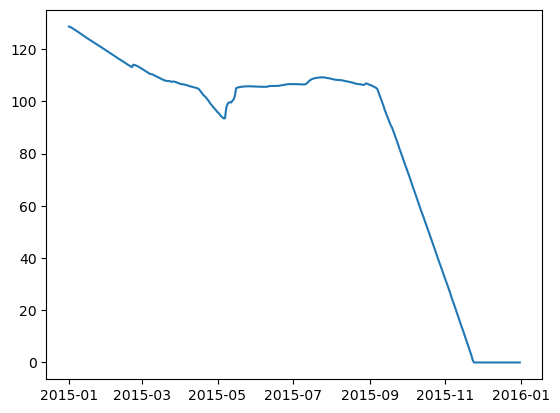

In [7]:
#Objective 2: hydropower

df15['release_cfs'] = df15.release / 1.98346
df15['release_powerplant'] = df15.release_cfs
df15.loc[df15.release_powerplant>5500,'release_powerplant']=5500
df15['height'] = df15['storage'].apply(height_from_stor)
df15['height'] = df15.height - 290
df15['power'] = df15.apply(lambda x: power(x['height'], x['release_powerplant']), 
                        axis=1)
plt.plot(df15.date, df15.power)


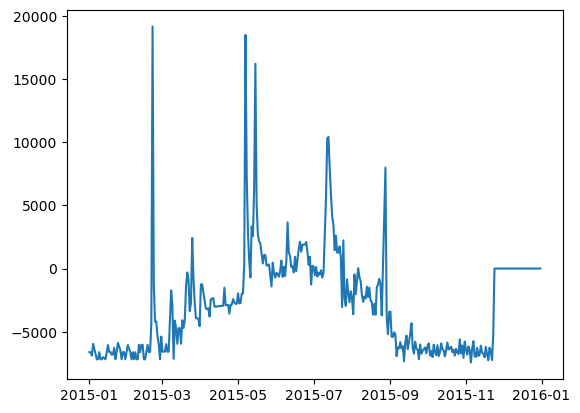

In [22]:
#Objective 3: environmental alteration (difference between inflows and outflows)

df15['env_alt'] = df15.inflows - df15.release

plt.plot(df15.date, df15.env_alt)

## The weighting method for multi-objective analysis (Loucks and van Beek 9.5.2)
    

Objective value for iteration  0  : 977815792.8708678
Objective value for iteration  1  : 880034213.5839832
Objective value for iteration  2  : 782252634.2968378
Objective value for iteration  3  : 684471055.0100006
Objective value for iteration  4  : 586689475.7227001
Objective value for iteration  5  : 488907896.43557984
Objective value for iteration  6  : 391126317.1484618
Objective value for iteration  7  : 293344737.86134565
Objective value for iteration  8  : 195563158.5742241
Objective value for iteration  9  : 97781579.287112
Objective value for iteration  10  : 7.396602232417564e-07


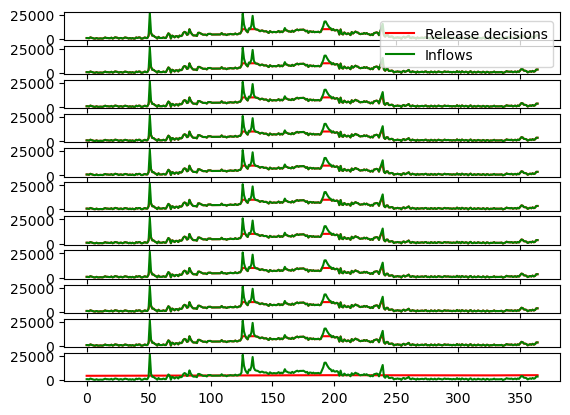

In [21]:
from pyomo.environ import *
from pyomo.opt import SolverStatus, TerminationCondition, SolverFactory


for j,w in enumerate(np.arange(0,1.01,0.1)):
   

    inflows = np.array(df15.inflows)
    demand = 10000*np.ones(T)


    model = ConcreteModel()

    model.N = list(range(len(inflows)))


    model.release = Var(model.N , within=NonNegativeReals)
    model.shortage = Var(model.N , within=NonNegativeReals)
    model.storage = Var(model.N , within=NonNegativeReals)


    model.Obj = Objective(expr=sum((w*(model.shortage[i]**2) + (1-w)*((inflows[i] - model.release[i])**2)) for i in model.N), sense=minimize)

    # Constraints
    def max_capacity(model, i):
        return model.storage[i] <= 2030000
    model.capacity_const = Constraint(model.N, rule=max_capacity)

    # Constraints
    def max_shortage(model, i):
        return model.shortage[i] <= demand[i] - model.release[i]
    model.shortage_const = Constraint(model.N, rule=max_shortage)

    def flow_rule(model, i):
       if i == 0:
          return Constraint.Skip
       else:
          return model.storage[i] - model.storage[i-1] - inflows[i-1] + model.release[i-1] == 0
    model.balance = Constraint(model.N , rule=flow_rule)

    model.constraints = ConstraintList()
    model.constraints.add(model.storage[0] == 1000000)


    # Optimize
    opt = SolverFactory("ipopt")


    results = opt.solve(model, tee=False)
    model.solutions.load_from(results)


    S_opt = np.array([value(model.storage[t]) for t in model.N])
    R_opt = np.array([value(model.release[t]) for t in model.N])

    print("Objective value for iteration ",j, " :", value(model.Obj))
    
    plt.subplot(11,1,j+1)
    plt.plot(R_opt, color='red', label='Release decisions')
    plt.plot(inflows, color='green', label = 'Inflows')
    if j==11:
        plt.legend()